##### Top

In [169]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiLineString
from shapely.ops import unary_union, linemerge
from shapely import simplify
import numpy as np
import matplotlib.pyplot as plt
import plotly_express as px
import plotly.graph_objects as go

import time
import os

from selenium import webdriver
import folium

pd.options.mode.chained_assignment = None

## save_folium_map()

In [116]:
def save_folium_map(m, save_path):
    import time
    
    delay=2
    fn='temp_map.html'
    tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
    m.save(fn)

    browser = webdriver.Firefox()
    browser.get(tmpurl)
    browser.set_window_size(1920, 1432)
    time.sleep(delay)
    browser.save_screenshot(save_path)
    browser.quit()

## Paths

In [117]:
def segments(curve):
    return list(map(LineString, zip(curve.coords[:-1], curve.coords[1:])))

Stations

In [360]:
stations_df = pd.read_csv("../data/raw/Helsingin_ja_Espoon_kaupunkipyöräasemat_avoin_7704606743268189464.csv")
stations_df["geometry"] = [Point(xy) for xy in zip(stations_df.x, stations_df.y)]
station_coords_dict = stations_df.set_index("ID")["geometry"].to_dict()

In [361]:
stations_df = stations_df.set_index("ID")

Path geometries and dict

In [348]:
path_geometries = gpd.read_file("../data/processed/journey_routes.gpkg")[["ids", "geometry"]].rename(columns={"ids":"path_id"})

In [ ]:
path_geometries = path_geometries.drop_duplicates("path_id")

mask = path_geometries["geometry"].apply(lambda x: type(x) == LineString)
path_geometries = path_geometries[mask]
path_geometries = path_geometries.reset_index(drop=True)
path_geometries["geometry"] = path_geometries["geometry"].apply(lambda line: LineString([(round(point[0], 4), round(point[1], 4)) for point in line.coords]))
path_geometries

In [ ]:
path_geometries_dict = path_geometries.set_index("path_id")["geometry"].to_dict()

Grouped counts - main df

In [350]:
pd.read_csv("../data/processed/grouped_counts.csv")

,Departure station id,Return station id,time,count,ids
0,1,1,00:00:00,25,"(1, 1)"
1,1,1,01:00:00,7,"(1, 1)"
2,1,1,02:00:00,10,"(1, 1)"
3,1,1,03:00:00,3,"(1, 1)"
4,1,1,04:00:00,2,"(1, 1)"
...,...,...,...,...,...
528441,999,312,07:00:00,1,"(312, 999)"
528442,999,364,23:00:00,1,"(364, 999)"
528443,999,573,20:00:00,1,"(573, 999)"
528444,999,627,18:00:00,1,"(627, 999)"


In [ ]:
data = pd.read_csv("../data/processed/grouped_counts.csv")
data["geometry"] = data["ids"].map(path_geometries_dict)
data = data.dropna()
data = data.reset_index(drop=True)
data

,Departure station id,Return station id,time,count,ids,geometry
0,1,2,00:00:00,2,"(1, 2)","LINESTRING (24.9503 60.1552, 24.9508 60.1553, ..."
1,1,2,01:00:00,1,"(1, 2)","LINESTRING (24.9503 60.1552, 24.9508 60.1553, ..."
2,1,2,03:00:00,1,"(1, 2)","LINESTRING (24.9503 60.1552, 24.9508 60.1553, ..."
3,1,2,07:00:00,1,"(1, 2)","LINESTRING (24.9503 60.1552, 24.9508 60.1553, ..."
4,1,2,08:00:00,11,"(1, 2)","LINESTRING (24.9503 60.1552, 24.9508 60.1553, ..."
...,...,...,...,...,...,...
515513,902,761,18:00:00,4,"(761, 902)","LINESTRING (24.8394 60.2206, 24.8394 60.2203, ..."
515514,902,763,17:00:00,4,"(763, 902)","LINESTRING (24.8338 60.2206, 24.8339 60.2206, ..."
515515,902,763,18:00:00,15,"(763, 902)","LINESTRING (24.8338 60.2206, 24.8339 60.2206, ..."
515516,902,763,21:00:00,2,"(763, 902)","LINESTRING (24.8338 60.2206, 24.8339 60.2206, ..."


In [ ]:
data["Departure station id"].nunique()

454

In [ ]:
from branca.colormap import LinearColormap

main_color = (254,138,24,255)
mid_color = tuple(x/2 for x in main_color)

# colors = [(0,0,0,0), (0,0,255,128), (255,255,255,255)] # white to blue to black
colors = [(0,0,0,0), (16*2, 1*2, 102*2, 128), (255,255,255,255)] # white to lightblue to black
# colors = [(255,255,255,0), (0,0,255,255)] # blue to white
# colors = [(255,255,255,0), (255,0,0,255)] # red to white

# colors = [(255,255,255,0), (128,0,0,128), (255,0,0,255)]
# colors = [(255,255,255,0), mid_color, main_color]


In [344]:
lon_center = stations_df["x"].mean()
lat_center = stations_df["y"].mean()

In [359]:
stations_df.loc[317].y

np.float64(60.2187766341847)

In [347]:
# station_group = [ # herttoniemenranta
#     # 260,
#     # 258,
#     # 259,
#     257,
#     256,
#     255,
#     254
#     ]

station_group = [ # steissi
    19,
    22,
    21
    ]

station_id = 270
# station_id = data["Departure station id"].unique()[np.random.randint(1,454)] # random
# time = "17:00:00"

morning_times = ["06:00:00", "07:00:00", "08:00:00", "09:00:00", "10:00:00"]
evening_times = ["14:00:00", "15:00:00", "16:00:00", "17:00:00", "18:00:00"]
nighttimes = ["23:00:00", "00:00:00", "01:00:00", "02:00:00", "03:00:00", "04:00:00"]

# data2 = data[(data["Departure station id"] == station_id) & (data["time"]==time)]
# data2 = data[(data["Departure station id"] == station_id) & (data["time"].isin(nighttimes))]
# data2 = data[(data["Departure station id"] == station_id)]

# data2 = data[(data["Departure station id"].isin(station_group)) & (data["time"]==time)]
# data2 = data[(data["Departure station id"].isin(station_group))]

# data2 = data[(data["Departure station id"] == station_id) & (data["time"].isin(morning_times))]
# data2 = data[(data["Departure station id"] == station_id) & (data["time"].isin(evening_times))]

# data2 = data[(data["Departure station id"].isin(station_group)) & (data["time"].isin(morning_times))]
data2 = data[(data["Departure station id"].isin(station_group)) & (data["time"].isin(evening_times))]



data2["segments"] = data2["geometry"].apply(lambda x: segments(x))

data2 = data2.explode("segments")
data2["segments_wkt"] = data2["segments"].apply(lambda x: x.wkt)
data2 = data2.groupby("segments_wkt").agg({"count":"sum", "segments":"first"}).reset_index()
data2 = data2.groupby("count")["segments"].apply(list).reset_index()
data2["segments"] = data2["segments"].apply(lambda x: unary_union(x))
data2["segments"] = data2["segments"].apply(lambda x: linemerge(x) if type(x) == MultiLineString else x)
data2["segments"] = data2["segments"].apply(lambda line: simplify(line, tolerance=0.00007))

gdf = gpd.GeoDataFrame(data2, geometry="segments", crs="EPSG:4326")
gdf["count"] = np.log2(gdf["count"] + 1)


custom_cmap = LinearColormap(colors, vmin=gdf["count"].min(), vmax=gdf["count"].max())

# print(station_id)

m = folium.Map(location=[lat_center, lon_center-0.1], zoom_start=12, tiles="CartoDB dark_matter",)
gdf.explore(m=m, column="count", cmap=custom_cmap, vmin=1, vmax=8)
# gpd.GeoDataFrame(geometry=[stations_df["geometry"][station_id]], crs=gdf.crs).explore(m=m, color="Yellow", marker_kwds={"radius":4}, style_kwds={"fillOpacity":1})
m

In [ ]:
save_folium_map(m=m, save_path="../presentation/vuosaari.png")

In [ ]:
def do_plot(time="16:00:00", station_id=541):
    data2 = data[(data["Departure station id"] == station_id) & (data["time"]==time)]
    # data2 = data[data["time"]==time]
    
    data2["segments"] = data2["geometry"].apply(lambda x: segments(x))

    data2 = data2.explode("segments")
    data2["segments_wkt"] = data2["segments"].apply(lambda x: x.wkt)
    data2 = data2.groupby("segments_wkt").agg({"count":"sum", "segments":"first"}).reset_index()
    data2 = data2.groupby("count")["segments"].apply(list).reset_index()
    data2["segments"] = data2["segments"].apply(lambda x: unary_union(x))
    data2["segments"] = data2["segments"].apply(lambda x: linemerge(x) if type(x) == MultiLineString else x)
    data2["segments"] = data2["segments"].apply(lambda line: simplify(line, tolerance=0.00007))

    gdf = gpd.GeoDataFrame(data2, geometry="segments", crs="EPSG:4326")
    gdf["count"] = np.log2(gdf["count"] + 1)
    return gdf

c:\Users\pyryp\anaconda3\envs\ox\Lib\site-packages\geopandas\plotting.py:658: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


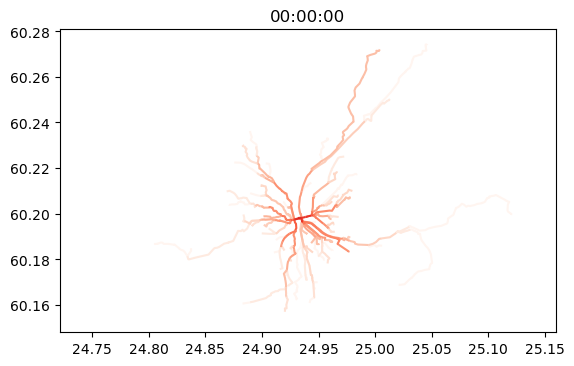

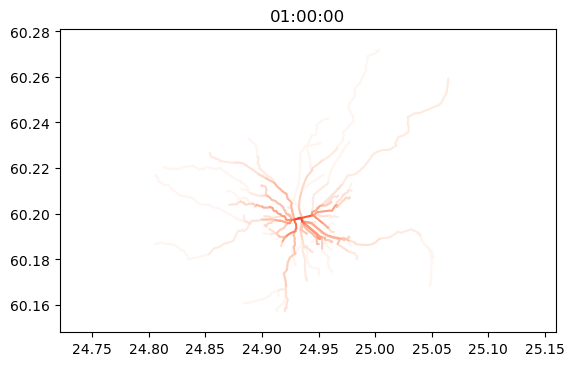

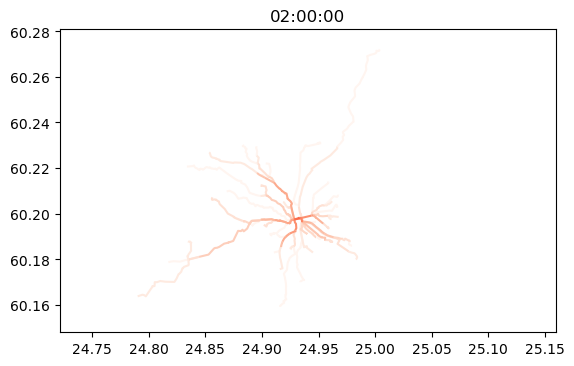

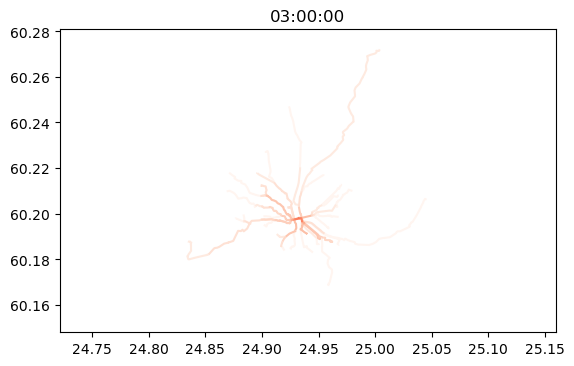

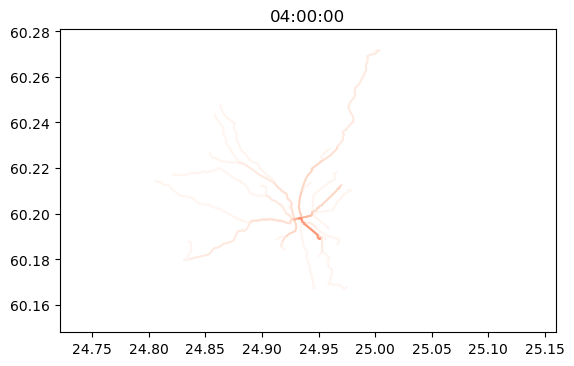

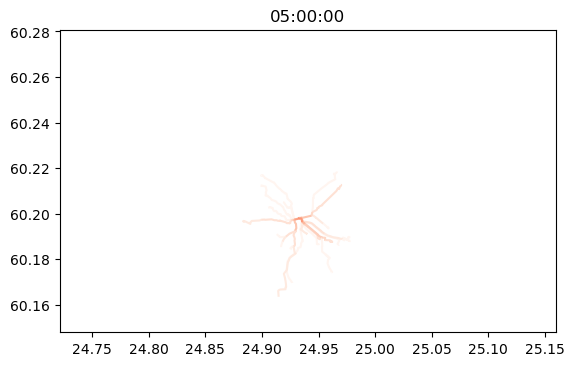

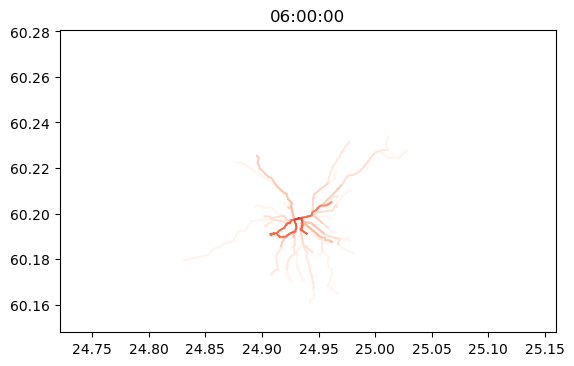

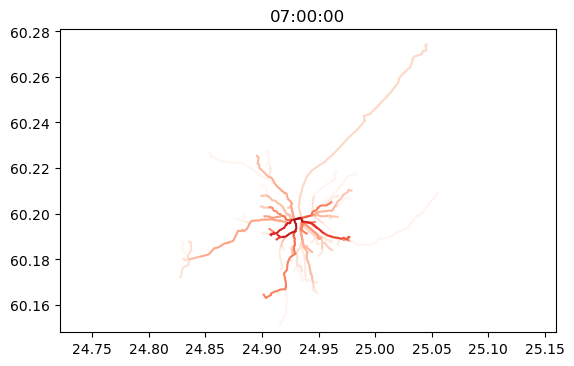

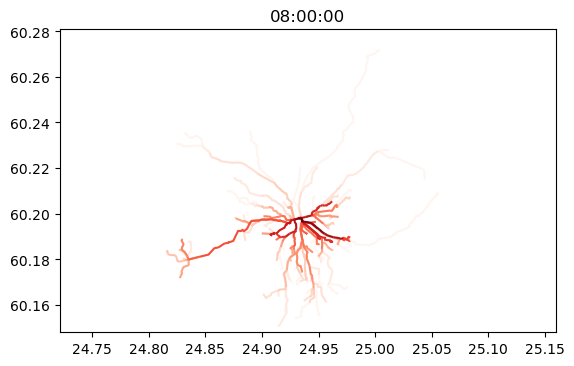

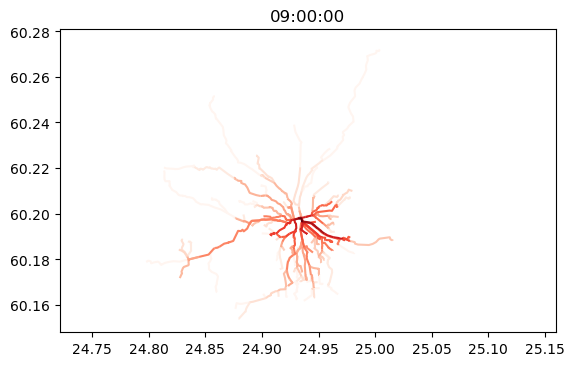

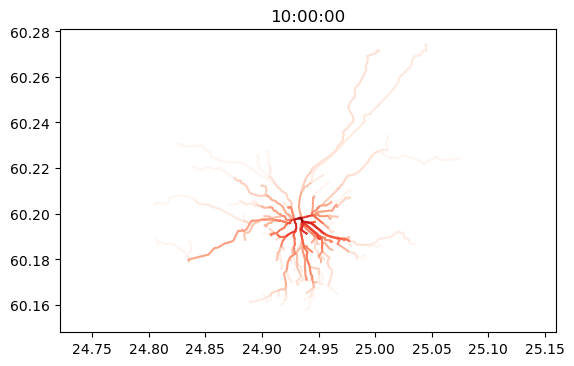

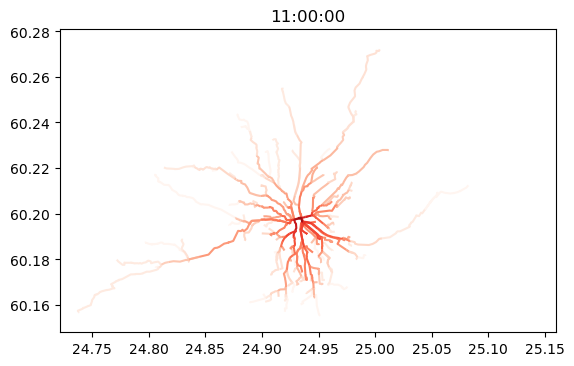

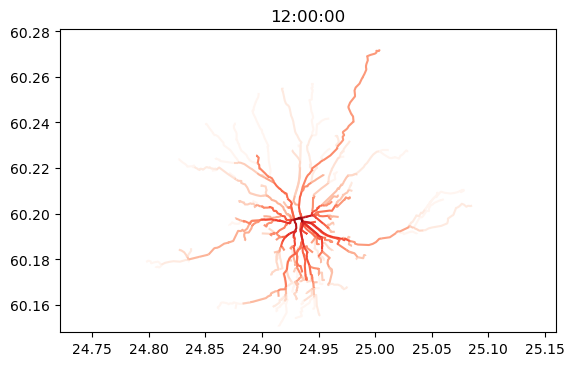

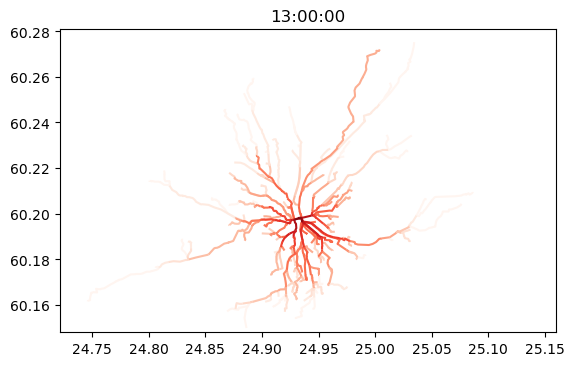

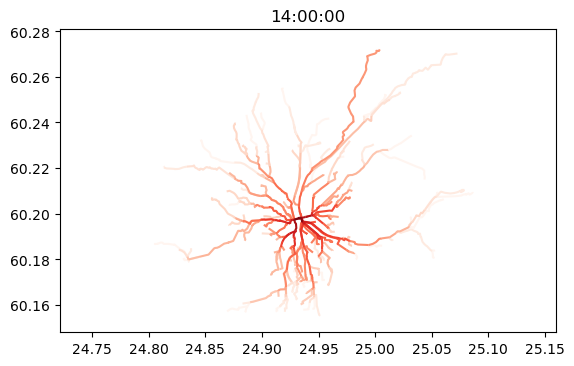

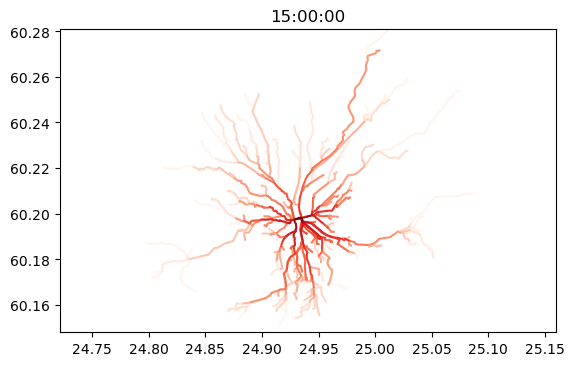

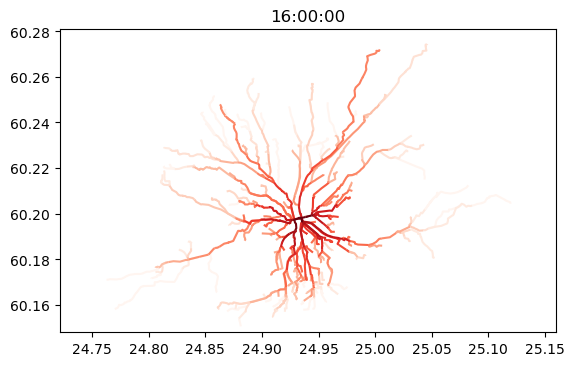

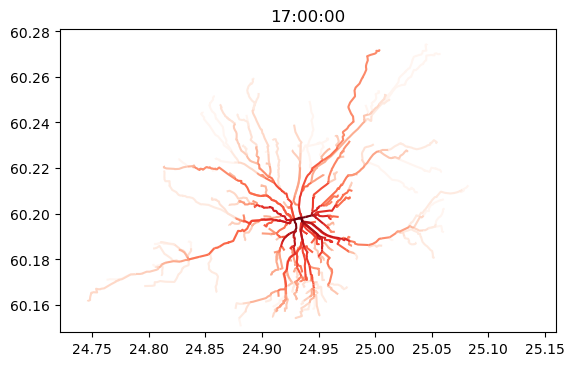

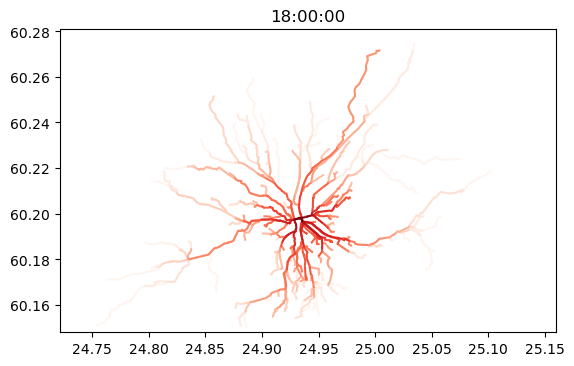

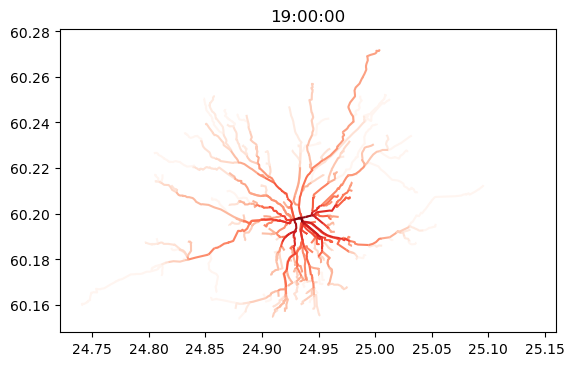

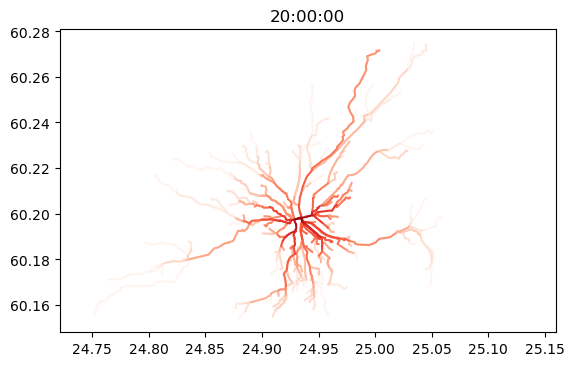

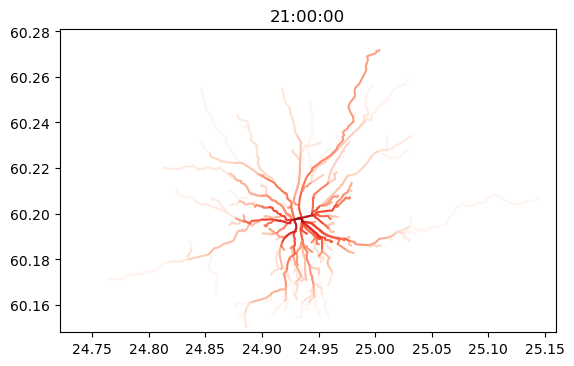

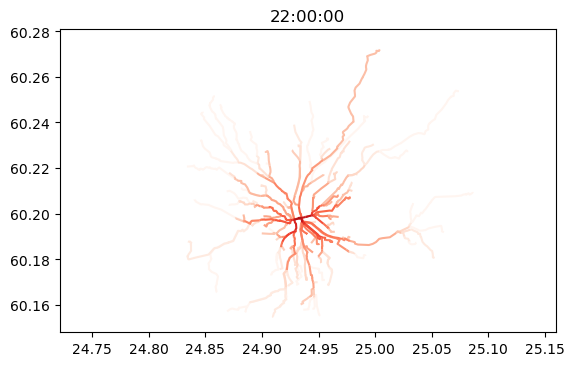

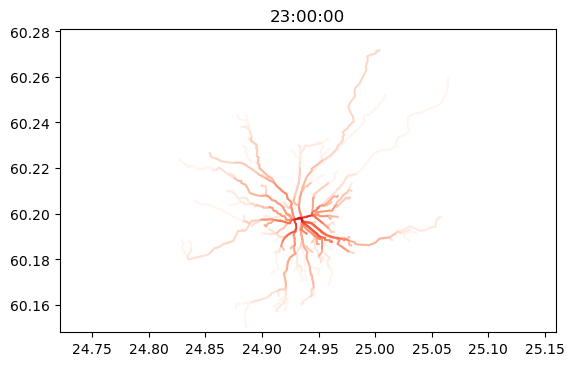

In [ ]:
for time in sorted(data["time"].unique()):
    gdf = do_plot(time, 113)
    try:
        ax = gdf.plot(column="count", cmap="Reds", vmax=9.5)
        ax.set_xlim([stations_df["x"].min(), stations_df["x"].max()])
        ax.set_ylim([stations_df["y"].min(), stations_df["y"].max()])
        ax.set_title(time)
        ax
        plt.savefig(f"../results/pasila_timelapse/{time[:2]}.png")
    except:
        pass

# Departure trend graphs

In [122]:
grouped_counts_df = pd.read_csv("../data/processed/grouped_counts.csv")
grouped_counts_df

,Departure station id,Return station id,time,count,ids
0,1,1,00:00:00,25,"(1, 1)"
1,1,1,01:00:00,7,"(1, 1)"
2,1,1,02:00:00,10,"(1, 1)"
3,1,1,03:00:00,3,"(1, 1)"
4,1,1,04:00:00,2,"(1, 1)"
...,...,...,...,...,...
528441,999,312,07:00:00,1,"(312, 999)"
528442,999,364,23:00:00,1,"(364, 999)"
528443,999,573,20:00:00,1,"(573, 999)"
528444,999,627,18:00:00,1,"(627, 999)"


<Axes: xlabel='time'>

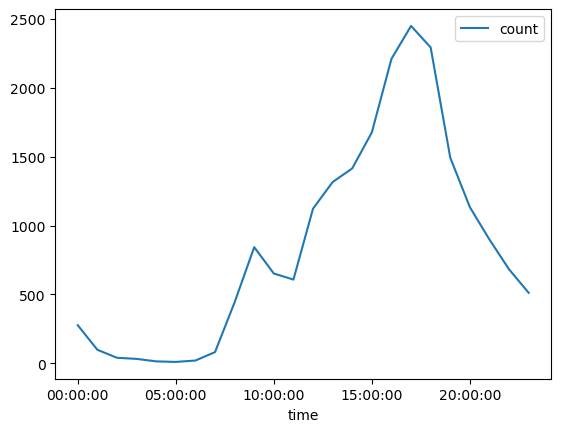

In [123]:
grouped_counts_df[grouped_counts_df["Departure station id"]==541].groupby("time")["count"].sum().reset_index().set_index("time").plot()

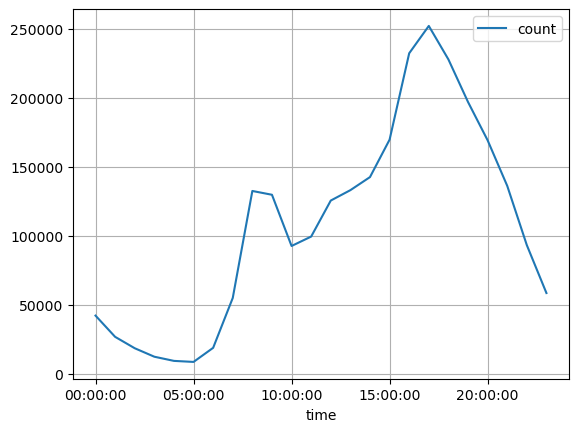

In [124]:
grouped_counts_df.groupby("time")["count"].sum().reset_index().set_index("time").plot()
plt.grid()

In [331]:
df = grouped_counts_df.groupby("time")["count"].sum().reset_index()
df["count"] = df["count"] / 214
df["time"] = pd.to_datetime(df["time"])

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df["time"],
        y=df["count"],
        mode="lines",
        line=dict(shape="spline", color="#100166", width=4)
    ))

fig.update_layout(
    plot_bgcolor="#FFFAF7", 
    paper_bgcolor="#FFFAF7", 
    showlegend=False, 
    width=850,
    height=650, 
    margin=dict(t=70),
    template="simple_white",
    # xaxis_title="time",
    # yaxis_title="trips per hour",
    title="Trips per hour",
    xaxis=dict(
        tickmode="auto",
        nticks=9,
        tickformat="%H:%M",
        ticklen=10
    ),
    yaxis=dict(showgrid=True, gridwidth=2, range=[0,1250], ticklen=10),
    font=dict(size=20)
    )

fig

C:\Users\pyryp\AppData\Local\Temp\ipykernel_9108\3314018312.py:3: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



## Weekends?

In [ ]:
trips_df = pd.read_csv("../data/processed/trips.csv")
trips_df

,Departure,Return,Departure station id,Departure station name,Return station id,Return station name,Covered distance (m),Duration (sec.)
0,2024-04-30T23:59:23,2024-05-01T00:31:48,18,Porthania,103,Korppaantie,6115.0,1941
1,2024-04-30T23:59:08,2024-05-01T00:01:25,259,Petter Wetterin tie,255,Laivalahden puistotie,614.0,133
2,2024-04-30T23:58:52,2024-05-01T00:03:26,36,Apollonkatu,77,Nordenskiöldinaukio,1108.0,270
3,2024-04-30T23:58:51,2024-05-01T00:15:50,294,Postipuisto,237,Aulangontie,4135.0,1002
4,2024-04-30T23:58:50,2024-05-01T00:22:30,44,Sörnäinen (M),116,Linnanmäki,1480.0,1415
...,...,...,...,...,...,...,...,...
2585663,2024-10-01T00:04:58,2024-10-01T00:12:40,135,Velodrominrinne,204,A.I. Virtasen aukio,1331.0,458
2585664,2024-10-01T00:04:23,2024-10-01T00:09:38,263,Herttoniemen kirkko,264,Eränkävijäntori,826.0,314
2585665,2024-10-01T00:02:52,2024-10-01T00:07:19,129,Pernajantie,44,Sörnäinen (M),937.0,261
2585666,2024-10-01T00:00:36,2024-10-01T00:17:21,401,Koivusaari (M),541,"Aalto-yliopisto (M), Korkeakouluaukio",3761.0,1000


In [54]:
trips_df["Departure"] = pd.to_datetime(trips_df["Departure"], format="mixed")
trips_df["time"] = trips_df["Departure"].dt.round(freq="60min").dt.time
trips_df["weekday"] = trips_df["Departure"].dt.dayofweek
trips_df

,Departure,Return,Departure station id,Departure station name,Return station id,Return station name,Covered distance (m),Duration (sec.),time,weekday
0,2024-04-30 23:59:23,2024-05-01T00:31:48,18,Porthania,103,Korppaantie,6115.0,1941,00:00:00,1
1,2024-04-30 23:59:08,2024-05-01T00:01:25,259,Petter Wetterin tie,255,Laivalahden puistotie,614.0,133,00:00:00,1
2,2024-04-30 23:58:52,2024-05-01T00:03:26,36,Apollonkatu,77,Nordenskiöldinaukio,1108.0,270,00:00:00,1
3,2024-04-30 23:58:51,2024-05-01T00:15:50,294,Postipuisto,237,Aulangontie,4135.0,1002,00:00:00,1
4,2024-04-30 23:58:50,2024-05-01T00:22:30,44,Sörnäinen (M),116,Linnanmäki,1480.0,1415,00:00:00,1
...,...,...,...,...,...,...,...,...,...,...
2585663,2024-10-01 00:04:58,2024-10-01T00:12:40,135,Velodrominrinne,204,A.I. Virtasen aukio,1331.0,458,00:00:00,1
2585664,2024-10-01 00:04:23,2024-10-01T00:09:38,263,Herttoniemen kirkko,264,Eränkävijäntori,826.0,314,00:00:00,1
2585665,2024-10-01 00:02:52,2024-10-01T00:07:19,129,Pernajantie,44,Sörnäinen (M),937.0,261,00:00:00,1
2585666,2024-10-01 00:00:36,2024-10-01T00:17:21,401,Koivusaari (M),541,"Aalto-yliopisto (M), Korkeakouluaukio",3761.0,1000,00:00:00,1


In [60]:
grouped_counts_df_wd = trips_df.groupby(["time", "weekday"])["Return"].count().reset_index().rename(columns={"Return": "count"})
grouped_counts_df_wd

,time,weekday,count
0,00:00:00,0,3958
1,00:00:00,1,4203
2,00:00:00,2,5150
3,00:00:00,3,5153
4,00:00:00,4,6966
...,...,...,...
163,23:00:00,2,8397
164,23:00:00,3,8698
165,23:00:00,4,10976
166,23:00:00,5,10053


In [84]:
df = grouped_counts_df_wd[grouped_counts_df_wd["weekday"]==5]
df = df.groupby("time")["count"].mean().reset_index().set_index("time")
px.line(df, width=600)

# Most traffic (hubs)

In [ ]:
grouped_counts_df = pd.read_csv("../data/processed/grouped_counts.csv")
grouped_counts_df

,Departure station id,Return station id,time,count,ids
0,1,1,00:00:00,25,"(1, 1)"
1,1,1,01:00:00,7,"(1, 1)"
2,1,1,02:00:00,10,"(1, 1)"
3,1,1,03:00:00,3,"(1, 1)"
4,1,1,04:00:00,2,"(1, 1)"
...,...,...,...,...,...
528441,999,312,07:00:00,1,"(312, 999)"
528442,999,364,23:00:00,1,"(364, 999)"
528443,999,573,20:00:00,1,"(573, 999)"
528444,999,627,18:00:00,1,"(627, 999)"


In [ ]:
hubs_df = grouped_counts_df.groupby("Departure station id")["count"].sum().reset_index()
hubs_df["coords"] = hubs_df["Departure station id"].map(station_coords_dict)
hubs_df = hubs_df.dropna()
# hubs_df["count"] = np.log10(hubs_df["count"])
# hubs_df["count"] = 1/hubs_df["count"]
hubs_df

,Return station id,count,coords
0,1,15501,POINT (24.9502114714031 60.155369615074)
1,2,7364,POINT (24.9565097715858 60.1609890692806)
2,3,9154,POINT (24.9450181631667 60.1581769029949)
3,4,10861,POINT (24.9417758006418 60.1609858921764)
4,5,12395,POINT (24.9362853002102 60.157948291819)
...,...,...,...
450,761,1382,POINT (24.83939 60.220467)
451,763,2525,POINT (24.833536 60.220551)
452,767,810,POINT (24.820635 60.223377)
454,900,2770,POINT (24.771826 60.180118)


In [160]:
gpd.GeoDataFrame(hubs_df, geometry="coords", crs="EPSG:4326").explore(tiles="CartoDB positron", column="count", marker_kwds={"radius":15}, cmap="Reds")

# Longest trips

In [ ]:
trips_df = pd.read_csv("../data/processed/trips.csv")
trips_df

,Departure,Return,Departure station id,Departure station name,Return station id,Return station name,Covered distance (m),Duration (sec.)
0,2024-04-30T23:59:23,2024-05-01T00:31:48,18,Porthania,103,Korppaantie,6115.0,1941
1,2024-04-30T23:59:08,2024-05-01T00:01:25,259,Petter Wetterin tie,255,Laivalahden puistotie,614.0,133
2,2024-04-30T23:58:52,2024-05-01T00:03:26,36,Apollonkatu,77,Nordenskiöldinaukio,1108.0,270
3,2024-04-30T23:58:51,2024-05-01T00:15:50,294,Postipuisto,237,Aulangontie,4135.0,1002
4,2024-04-30T23:58:50,2024-05-01T00:22:30,44,Sörnäinen (M),116,Linnanmäki,1480.0,1415
...,...,...,...,...,...,...,...,...
2585663,2024-10-01T00:04:58,2024-10-01T00:12:40,135,Velodrominrinne,204,A.I. Virtasen aukio,1331.0,458
2585664,2024-10-01T00:04:23,2024-10-01T00:09:38,263,Herttoniemen kirkko,264,Eränkävijäntori,826.0,314
2585665,2024-10-01T00:02:52,2024-10-01T00:07:19,129,Pernajantie,44,Sörnäinen (M),937.0,261
2585666,2024-10-01T00:00:36,2024-10-01T00:17:21,401,Koivusaari (M),541,"Aalto-yliopisto (M), Korkeakouluaukio",3761.0,1000


In [148]:
trips_df.groupby("Departure station id")["Covered distance (m)"].mean().reset_index().sort_values("Covered distance (m)", ascending=False)

,Departure station id,Covered distance (m)
317,376,5558.007756
318,377,5130.662658
291,350,5002.048847
280,339,4959.486578
279,338,4761.634096
...,...,...
376,555,815.391632
394,595,660.827769
359,523,642.804540
222,271,-51.883311


## Stats

In [166]:
stats_df = trips_df.groupby("Return station id")["Covered distance (m)"].agg(["mean", "std"]).reset_index()
stats_df["coords"] = stats_df["Return station id"].map(station_coords_dict)
stats_df = stats_df.dropna()
stats_df = stats_df[stats_df["mean"]>0]
stats_df["std"] = np.log2(stats_df["std"])
stats_df

,Return station id,mean,std,coords
0,1,3210.954177,11.109045,POINT (24.9502114714031 60.155369615074)
1,2,2501.186701,10.927980,POINT (24.9565097715858 60.1609890692806)
2,3,2553.327720,10.890421,POINT (24.9450181631667 60.1581769029949)
3,4,2395.041125,10.970834,POINT (24.9417758006418 60.1609858921764)
4,5,2569.734211,10.984394,POINT (24.9362853002102 60.157948291819)
...,...,...,...,...
450,761,3493.223913,11.690819,POINT (24.83939 60.220467)
451,763,3205.588981,11.665620,POINT (24.833536 60.220551)
452,767,2091.525926,11.170947,POINT (24.820635 60.223377)
454,900,1919.646782,10.941418,POINT (24.771826 60.180118)


In [167]:
gpd.GeoDataFrame(stats_df, geometry="coords", crs="EPSG:4326").explore(tiles="CartoDB positron", column="mean", marker_kwds={"radius":15})

# Diversity of route usge

In [187]:
grouped_counts_df = pd.read_csv("../data/processed/grouped_counts.csv")
grouped_counts_df

,Departure station id,Return station id,time,count,ids
0,1,1,00:00:00,25,"(1, 1)"
1,1,1,01:00:00,7,"(1, 1)"
2,1,1,02:00:00,10,"(1, 1)"
3,1,1,03:00:00,3,"(1, 1)"
4,1,1,04:00:00,2,"(1, 1)"
...,...,...,...,...,...
528441,999,312,07:00:00,1,"(312, 999)"
528442,999,364,23:00:00,1,"(364, 999)"
528443,999,573,20:00:00,1,"(573, 999)"
528444,999,627,18:00:00,1,"(627, 999)"


Number of routes

In [197]:
df = grouped_counts_df.groupby(["Departure station id"])["Return station id"].nunique().reset_index().rename(columns={"Return station id":"count"})
df["coords"] = df["Departure station id"].map(station_coords_dict)
gdf = gpd.GeoDataFrame(df, geometry="coords", crs="EPSG:4326")
gdf.explore(tiles="Cartodb positron", column="count", marker_kwds={"radius":15})

Std

In [209]:
df = grouped_counts_df.groupby(["Departure station id", "Return station id"])["count"].sum().reset_index()
df = df.groupby("Departure station id")["count"].std().reset_index().rename(columns={"count":"std"})
df["coords"] = df["Departure station id"].map(station_coords_dict)
df.dropna(inplace=True)
df["std"] = np.log2(df["std"])
gdf = gpd.GeoDataFrame(df, geometry="coords", crs="EPSG:4326")
gdf.explore(tiles="Cartodb positron", column="std", marker_kwds={"radius":15})

Entropy

In [213]:
route_counts = grouped_counts_df.groupby(['Departure station id', 'Return station id']).size().reset_index(name='count')

# 2. For each departure station, calculate the proportion of trips to each return station
route_counts['total'] = route_counts.groupby('Departure station id')['count'].transform('sum')
route_counts['p_i'] = route_counts['count'] / route_counts['total']

# 3. Calculate Shannon entropy for each departure station
entropy_per_station = route_counts.groupby('Departure station id')["p_i"].apply(
    lambda x: -np.sum(x * np.log(x))).reset_index(name='entropy')

entropy_per_station

,Departure station id,entropy
0,1,5.173504
1,2,4.958100
2,3,4.990779
3,4,5.092501
4,5,5.116771
...,...,...
453,768,4.475976
454,900,4.163968
455,902,4.076548
456,997,2.821564


In [214]:
entropy_per_station["coords"] = entropy_per_station["Departure station id"].map(station_coords_dict)

gdf = gpd.GeoDataFrame(entropy_per_station, geometry="coords", crs="EPSG:4326")
gdf.explore(tiles="Cartodb positron", column="entropy", marker_kwds={"radius":15})